# Predicting Building Energy Use

<img src="https://www.pikpng.com/pngl/m/152-1524338_overlay-city-drawing-easy-city-landscape-drawing-clipart.png" alt="Overlay City Drawing - Easy City Landscape Drawing Clipart@pikpng.com" class="center">

### Business Understanding

Buildings account for 76% of all electricity use in the United States. This translates to 40% of total greenhouse gas emissions from baseline power (coal and oil). Over half of a buildings energy draw comes from environment control:

* lighting
* cooling
* heating
* ventilation
* refrigeration

<img src="images/piechart.png" class="center">

New York State Energy Plan:

*"The State Energy Plan is a comprehensive roadmap to build a clean, resilient, and affordable energy system for all New Yorkers. The Plan coordinates every State agency and authority that touches energy to advance the REV agenda, unleashing groundbreaking regulatory reform to integrate clean energy into the core of our power grid, redesigning programs to unlock private capital, and actively deploying innovative energy solutions across the State’s own public facilities and operations."* ([EnergyPlan.NY.gov](https://energyplan.ny.gov/))

The plan has the following goals for the state:

* 40% reduction in greenhouse gas emissions from 1990 levels
* 50% of energy generation from renewable energy sources
* 600 trillion Btu increase in statewide energy efficiency

Being able to predict the annual electricity usage of a building based on it's size, primary use and energy efficiency rating would allow for better municipal planning and could help with identifying buildings that over-consume. This would be ideal for planning city sustainability projects as energy consumption could be predicted based on a forecasted change in energy efficiency of buildings. Based on required energy reductions predicted by this model the state could tailor sustainability programs to incentivize building managers to increase energy efficiency (reduce energy consumption).

### Data Understanding

**Target Variable - Annual Energy Usage (kW h):**
Energy use is typically tracked in kWh using electric meters installed by a utility company. NYC's Local Law 87 requires that buildings over 50,000 sqft undergo energy audits which include accurate, annual reporting of energy usage. Over 30,000 buildings within New York City fall under this law.

<img src="images/smart_meter.jpg" class="center">

**Building Energy Efficiency:**
A building's EnergyStar Score is a relative benchmark to other buildings of similar qualities. The higher the score the more energy efficient that building is. An EnergyStar Score of 50 is the median energy efficiency. In the state of New York, buildings above an EnergyStar Score of 70 are eligible for rebates through special state run programs.

**Primary Use:**
The primary use of a building is a general building classification. The top 5 classifications:
1. Multifamily Housing
2. Office
3. K-12 School
4. College/University
5. Hotel

In [409]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from statsmodels.formula.api import ols
from statsmodels.api import qqplot

from scipy import stats

In [410]:
df_meta = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/building_metadata.csv')
df = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/train.csv')
df_weather = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/weather_train.csv')

In [411]:
x_train_ids = '436 822 428 770 753 821 892 1099 726 904 923 233 985 1163 829 1212 1320 384 916 1365 1176 781 386 1157 1057 1004 1313 1043 908 496 894 318 295 409 1084 1342 565 887 720 222 1274 1082 198 915 966 443 782 1353 888 452 1255 1396 205 445 1414 335 645 1341 734 900 1276 902 836 374 451 133 1034 1199 449 843 813 585 469 1101 806 1270 1191 432 661 897 397 1197 290 376 1233 190 175 702 975 788 434 882 1109 447 1263 1249 1436 1409 108 355 743 1188 308 862 282 1009 1279 1445 889 1293 895 1423 787 110 334 1181 967 377 1154 858 1178 149 1298 1311 1301 649 1433 647 979 342 250 296 251 1346 629 117 1146 1060 796 771 677 1296 413 408 666 455 809 1102 1291 291 186 690 418 1193 733 614 981 697 1281 848 107 111 998 883 1175 1379 1306 812 689 634 381 907 169 549 606 1247 856 986 1091 1076 1148 249 964 1228 309 716 163 919 213 350 528 224 1440 631 387 401 939 257 369 211 1047 215 394 1216 1360 1347 182 1161 1395 234 323 284 600 740 974 202 160 1052 580 354 508 665 620 1261 148 756 1183 1053 414 814 582 442 1334 272 1266 581 949 1411 540 708 876 864 1026 917 331 1203 868 264 678 475 1221 1337 799 1071 1039 695 152 440 802 837 1010 709 680 826 256 327 303 181 833 1288 1278 1185 608 292 263 297 1224 279 1331 502 165 1251 1300 935 1067 1219 805 1194 344 1407 1069 765 244 741 153 698 643 472 1265 1003 380 990 710 285 114 1289 715 1310 1041 869 973 885 1339 504 471 593 1182 541 573 1364 816 385 157 970 112 367 465 969 911 516 278 679 718 760 1000 851 682 276 228 1336 1321 586 548 1258 357 497 648 650 1206 630 271 483 556 411 424 1208 417 872 1083 1273 127 827 604 688 952 1033 105 976 1215 1377 1165 859 838 598 1325 566 1290 398 518 345 320 506 579 567 1126 711 253 412 797 473 903 1015 1235 1345 1158 989 1022 281 922 1169 537 173 136 599 850 775 559 429 312 569 167 1035 273 1439 258 984 1280 337 694 845 632 507 415 852 1352 1074 584 192 602 352 1119 941 484 1142 1303 1428 1355 162 1324 839 597 1137 993 435 1238 1030 847 778 1314 724 390 655 1267 1054 1045 572 123 1229 154 1257 310 1312 235 732 633 738 448 610 995 425 185 853 194 370 246 842'
x_train_ids_list = [int(x) for x in x_train_ids.split()]

<AxesSubplot:xlabel='timestamp'>

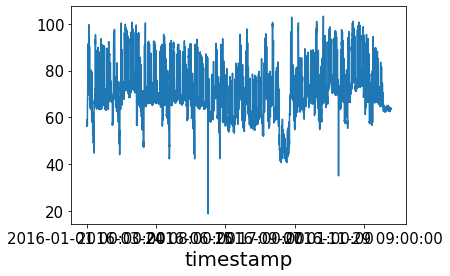

In [412]:
df[(df.building_id == 1057) & (df.meter==0)].set_index('timestamp')['meter_reading'].plot()

In [413]:
df[df.building_id==1353]

,building_id,meter,timestamp,meter_reading
2129,1353,0,2016-01-01 00:00:00,3.9000
2130,1353,1,2016-01-01 00:00:00,2.6069
4422,1353,0,2016-01-01 01:00:00,3.9750
4423,1353,1,2016-01-01 01:00:00,2.5244
6721,1353,0,2016-01-01 02:00:00,3.9250
...,...,...,...,...
20211189,1353,1,2016-12-31 21:00:00,2.5350
20213554,1353,0,2016-12-31 22:00:00,2.4500
20213555,1353,1,2016-12-31 22:00:00,2.4909
20215920,1353,0,2016-12-31 23:00:00,2.4000


In [414]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[df['meter'] == 0]

# def fix_streaks(dataframe,column_name,building_ids):
#     df_mod_x = pd.DataFrame()
#     for i in range(1449):
#         normal_df = pd.DataFrame()
#         duration_mod = 0
#         normal_df = dataframe[dataframe.building_id==i]
#         if i in building_ids:
#             normal_df = normal_df[(np.abs(stats.zscore(normal_df['meter_reading'])) < 2)]
#             groups = normal_df.groupby((normal_df[column_name] != normal_df[column_name].shift()).cumsum())
#             last = groups.last()
#             max_duration = (last['timestamp'] - groups.first().timestamp).nlargest(1)
#             try:
#                 duration = int(str(max_duration.iat[0]).split()[0])
#             except:
#                 duration = 0
#             if duration > 24:
#                 index_val = max_duration.index[0] - 1
#                 normal_df = normal_df.replace(range(index_val,index_val+duration),np.mean(normal_df.meter_reading))
#             else:
#                 normal_df.reset_index(inplace=True,drop=True)
#                 df_mod_x = pd.concat([df_mod_x,normal_df.copy(deep=True)])
#                 still_streaking = False
#         else:
#             normal_df.reset_index(inplace=True,drop=True)
#             df_mod_x = pd.concat([df_mod_x,normal_df.copy(deep=True)])

#     return df_mod_x

def fix_streaks(dataframe,column_name,building_ids):
    df_mod_x = pd.DataFrame()
    for i in range(1449):
        normal_df = pd.DataFrame()
        normal_df = dataframe[dataframe.building_id==i]
        if i in building_ids:
            normal_df = normal_df[(np.abs(stats.zscore(normal_df['meter_reading'])) < 3)]
            if normal_df.shape[0]<7500:
                normal_df = normal_df.set_index('timestamp').resample('H').mean().fillna(normal_df['meter_reading'].mean())
                normal_df.reset_index(inplace=True)
                df_mod_x = pd.concat([df_mod_x,normal_df.copy(deep=True)])
            else:
                normal_df.reset_index(inplace=True,drop=True)
                df_mod_x = pd.concat([df_mod_x,normal_df.copy(deep=True)])
        else:
            normal_df.reset_index(inplace=True,drop=True)
            df_mod_x = pd.concat([df_mod_x,normal_df.copy(deep=True)])

    return df_mod_x

df_mod = fix_streaks(df,'meter_reading',x_train_ids_list)

In [415]:
meter_data_list = []
for i in df['building_id'].unique():
    df_temp = pd.DataFrame()
    df_temp = df_mod[df_mod['building_id'] == i].copy(deep=True)
    df_temp.set_index('timestamp',inplace=True)
    df_temp = df_temp.groupby('building_id').resample('A').sum()
    df_temp['building_id'] = i
    # df_temp.building_id.ffill(inplace=True)
    meter_data_list.append(df_temp)

df_meter_daily = pd.DataFrame()
for dataframe in meter_data_list:
    dataframe.reset_index(drop=True,inplace=True) 
    df_meter_daily = pd.concat([df_meter_daily,dataframe])

df_meter_daily.drop(['meter'],axis=1,inplace=True)

In [416]:
df_meter_daily

,building_id,meter_reading
0,0,1.286461e+06
0,1,6.576176e+05
0,2,1.278194e+05
0,3,2.069071e+06
0,4,8.578074e+06
...,...,...
0,567,5.607535e+05
0,621,5.077175e+04
0,591,5.205144e+04
0,1325,3.462946e+04


In [417]:
df_meter_daily.reset_index(inplace=True,drop=True)
df_meta_energy = df_meta.merge(df_meter_daily,how='right',on='building_id')

In [418]:
df_meta_energy = df_meta_energy[df_meta_energy['building_id'] > 104]

In [419]:
use_dict = {}

for use in df_meta_energy['primary_use'].unique():
    if df_meta_energy[df_meta_energy['primary_use'] == use]['floor_count'].isna().sum() == df_meta_energy[df_meta_energy['primary_use'] == use]['floor_count'].shape[0]:
        use_dict[use] = 1
    else:
        use_dict[use] = round(df_meta_energy[df_meta_energy['primary_use'] == use]['floor_count'].median())

def get_num_floors(num_floors):
    if num_floors > 0:
        return num_floors
    else:
        return use_dict[use]

def impute_num_floors(dataframe):
    metadata_list = []
    for idx,use in enumerate(dataframe['primary_use'].unique()):
        df_temp = pd.DataFrame()
        df_temp = dataframe[dataframe['primary_use'] == use].copy(deep=True)
        df_temp['floor_count'] = df_temp['floor_count'].map(get_num_floors)
        metadata_list.append(df_temp.copy(deep=True))

    df_imputed = pd.DataFrame()
    for dataframe in metadata_list:
        df_imputed = pd.concat([df_imputed,dataframe])

    df_imputed.drop(['year_built'],inplace=True,axis=1)
    return df_imputed

df_meta_energy = impute_num_floors(df_meta_energy)
df_meta_energy.set_index('building_id',inplace=True)

In [420]:
df_meta_energy.value_counts('floor_count')

floor_count
1.0     1064
2.0       67
4.0       37
3.0       32
5.0       25
6.0       25
8.0       18
7.0       14
9.0        8
11.0       5
10.0       4
12.0       2
13.0       2
21.0       1
14.0       1
16.0       1
19.0       1
26.0       1
dtype: int64

In [421]:
# X_train,X_test,y_train,y_test = train_test_split(df_meta_energy.drop(['meter_reading'],axis=1),df_meta_energy[['meter_reading']],random_state=42)

In [422]:
x_test_drop_list = []
x_train_drop_list = []
x_test_ids_list = []

for x in df_meta_energy.index:
    if x not in x_train_ids_list:
        x_train_drop_list.append(x)

for x in x_train_ids_list:
    if x in df_meta_energy.index:
        x_test_drop_list.append(x)

train_df = df_meta_energy.drop(x_train_drop_list)
test_df = df_meta_energy.drop(x_test_drop_list)

In [423]:
X_train = train_df.drop('meter_reading',axis=1)
y_train = train_df[['meter_reading']].copy(deep=True)
y_train['meter_reading'] = y_train['meter_reading'].map(np.log1p)

X_test = test_df.drop('meter_reading',axis=1)
y_test = test_df[['meter_reading']].copy(deep=True)
y_test['meter_reading'] = y_test['meter_reading'].map(np.log1p)

In [424]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe_train_array = ohe.fit_transform(X_train[['primary_use']])
ohe_train_df = pd.DataFrame(ohe_train_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

ohe_test_array = ohe.transform(X_test[['primary_use']])
ohe_test_df = pd.DataFrame(ohe_test_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

X_train.reset_index(inplace=True)
X_train_ohe = pd.concat([X_train,ohe_train_df],axis=1)
X_train_ohe.drop(['primary_use'],axis=1,inplace=True)

X_test.reset_index(inplace=True)
X_test_ohe = pd.concat([X_test,ohe_test_df],axis=1)
X_test_ohe.drop(['primary_use'],axis=1,inplace=True)

In [425]:
site_dict = {0:'Jacksonville',1:'Eilat',2:'Phoenix',3:'Philadelphia',4:'San Francisco',5:'Jerusalem',6:'Philadelphia',7:'Montreal',8:'Jacksonville',
             9:'San Antonio',10:'Las Vegas',11:'Montreal',12:'Tel Aviv District',13:'Minneapolis',14:'Baltimore',15:'Toronto'}

ohe_train_array = ohe.fit_transform(X_train_ohe[['site_id']])
ohe_train_df = pd.DataFrame(ohe_train_array.todense(),columns=[site_dict[int(name[3:])] for name in ohe.get_feature_names()])

ohe_test_array = ohe.transform(X_test_ohe[['site_id']])
ohe_test_df = pd.DataFrame(ohe_test_array.todense(),columns=[site_dict[int(name[3:])] for name in ohe.get_feature_names()])

X_train_ohe.reset_index(inplace=True,drop=True)
X_train_ohe = pd.concat([X_train_ohe,ohe_train_df],axis=1)
X_train_ohe.drop(['site_id'],axis=1,inplace=True)

X_test_ohe.reset_index(inplace=True,drop=True)
X_test_ohe = pd.concat([X_test_ohe,ohe_test_df],axis=1)
X_test_ohe.drop(['site_id'],axis=1,inplace=True)

X_train_ohe.set_index('building_id',inplace=True)
X_test_ohe.set_index('building_id',inplace=True)

In [426]:
lr = LinearRegression()
lr.fit(X_train_ohe,y_train)
lr.score(X_test_ohe,y_test)

0.4418971301694241

In [427]:
cross_val_score(lr,X_train_ohe,y_train,cv=7)

array([0.38375572, 0.19447944, 0.44128925, 0.32950566, 0.42306623,
       0.45242472, 0.33863496])

In [428]:
X_train_ohe

,square_feet,floor_count,Education,Entertainment/public assembly,Food sales and service,Healthcare,Lodging/residential,Manufacturing/industrial,Office,Other,...,Philadelphia,Montreal,Jacksonville,San Antonio,Las Vegas,Montreal,Tel Aviv District,Minneapolis,Baltimore,Toronto
building_id,,,,,,,,,,,,,,,,,,,,,
105,50623,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,97532,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,81580,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,27814,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,118338,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,11302,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
892,481999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
970,346056,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [429]:
y_test_preds = lr.predict(X_test_ohe)
y_train_preds = lr.predict(X_train_ohe)

In [430]:
y_test_preds = pd.DataFrame(y_test_preds,index=X_test_ohe.index,columns=['predictions_lr'])
y_train_preds = pd.DataFrame(y_train_preds,index=X_train_ohe.index,columns=['predictions_lr'])

In [431]:
y_test_results = y_test.join(y_test_preds)
y_train_results = y_train.join(y_train_preds)

In [432]:
# y_test_results['residual'] = np.abs(y_test_results['meter_reading'].map(np.expm1) - y_test_results['predictions'].map(np.expm1))
# y_train_results['residual'] = np.abs(y_train_results['meter_reading'].map(np.expm1) - y_train_results['predictions'].map(np.expm1))

y_test_results['residual_lr'] = y_test_results['meter_reading'] - y_test_results['predictions_lr']
y_train_results['residual_lr'] = y_train_results['meter_reading'] - y_train_results['predictions_lr']

In [433]:
np.sqrt(mean_squared_error(y_test,y_test_preds))

1.136478824721828

In [434]:
y_test_results.describe()

,meter_reading,predictions_lr,residual_lr
count,832.000000,832.000000,832.000000
mean,13.166363,13.103144,0.063219
std,1.522178,1.186344,1.135402
min,7.276581,10.162868,-4.921889
25%,12.334809,12.442847,-0.463920
50%,13.222743,13.071361,0.116095
75%,14.129210,13.591464,0.724236
max,17.525004,19.283974,5.573068


In [435]:
y_test_results['meter_reading'].map(np.expm1)

building_id
106     1.334165e+04
109     2.247810e+06
113     3.197152e+06
115     4.307476e+06
116     1.470527e+06
            ...     
944     1.098816e+06
982     1.034066e+06
1115    2.573751e+05
1118    1.693536e+05
1120    6.945796e+05
Name: meter_reading, Length: 832, dtype: float64

In [436]:
y_test_results['predictions_lr'].map(np.expm1)

building_id
106     3.652539e+05
109     7.934144e+05
113     1.934772e+06
115     1.421600e+06
116     5.652299e+05
            ...     
944     1.982896e+06
982     1.740967e+06
1115    1.457355e+05
1118    1.291121e+05
1120    1.824433e+05
Name: predictions_lr, Length: 832, dtype: float64

In [437]:
np.sqrt(mean_squared_error(y_test_results['meter_reading'].map(np.expm1),y_test_results['predictions_lr'].map(np.expm1)))

12283309.55349706

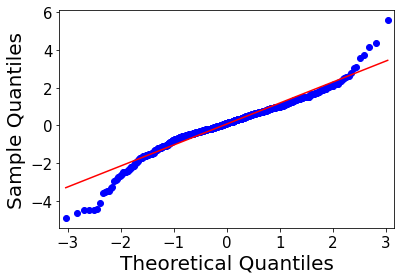

In [438]:
qqplot(y_test_results['residual_lr'],line='r')
plt.show()

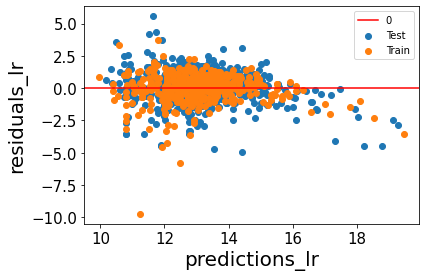

In [439]:
plt.scatter(y_test_results['predictions_lr'], y_test_results['residual_lr'], label='Test')
plt.scatter(y_train_results['predictions_lr'], y_train_results['residual_lr'], label='Train')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions_lr')
plt.ylabel('residuals_lr')
plt.legend()
plt.show()

In [440]:
rfr = RandomForestRegressor(n_estimators=10,max_depth=5)
rfr.fit(X_train_ohe,y_train['meter_reading'])
rfr.score(X_test_ohe,y_test['meter_reading'])

0.6105989814541926

In [441]:
params = {'n_estimators':np.linspace(200,400,num=10,dtype=int),
          'max_depth': np.linspace(1,10,num=5,dtype=int),
          'min_samples_split': np.linspace(2,10,num=5,dtype=int)}

gs = GridSearchCV(rfr,params)

gs.fit(X_train_ohe,y_train['meter_reading'])

In [442]:
# gs.best_params_

In [443]:
rfr = RandomForestRegressor(n_estimators=200,min_samples_split=6,max_depth=7)
rfr.fit(X_train_ohe,y_train['meter_reading'])
rfr.score(X_test_ohe,y_test['meter_reading'])

0.6393685409772182

In [444]:
cross_val_score(rfr,X_train_ohe,y_train['meter_reading'])

array([0.70490929, 0.4522002 , 0.6081802 , 0.51815286, 0.49762097])

In [445]:
rfe = RFE(rfr,n_features_to_select=10)
rfe.fit(X_train_ohe,y_train['meter_reading'])

RFE(estimator=RandomForestRegressor(max_depth=7, min_samples_split=6,
                                    n_estimators=200),
    n_features_to_select=10)

In [446]:
rfe.score(X_test_ohe,y_test['meter_reading'])

0.640112804535588

In [447]:
np.expm1(y_test)

,meter_reading
building_id,
106,1.334165e+04
109,2.247810e+06
113,3.197152e+06
115,4.307476e+06
116,1.470527e+06
...,...
944,1.098816e+06
982,1.034066e+06
1115,2.573751e+05


In [448]:
np.expm1(y_test).describe()

,meter_reading
count,8.320000e+02
mean,1.468593e+06
std,3.239708e+06
min,1.445035e+03
25%,2.274800e+05
50%,5.527971e+05
75%,1.368478e+06
max,4.083313e+07


In [449]:
y_test

,meter_reading
building_id,
106,9.498721
109,14.625467
113,14.977771
115,15.275863
116,14.201132
...,...
944,13.909745
982,13.849010
1115,12.458294


In [450]:
y_test_hat = rfr.predict(X_test_ohe)
np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_test_hat)))

2557510.943232314

In [451]:
cross_val_score(rfe,X_train_ohe,y_train['meter_reading'])

array([0.67340517, 0.44802104, 0.58937208, 0.57157794, 0.53780853])

In [452]:
keep_list = [(k,v) for k,v in zip(X_train_ohe.columns,rfe.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
keep_string = keep_string[:-1]
[ x[0] for x in keep_list if x[1] ]

['square_feet',
 'floor_count',
 'Entertainment/public assembly',
 'Lodging/residential',
 'Other',
 'Services',
 'Utility',
 'San Francisco',
 'Jerusalem',
 'Toronto']

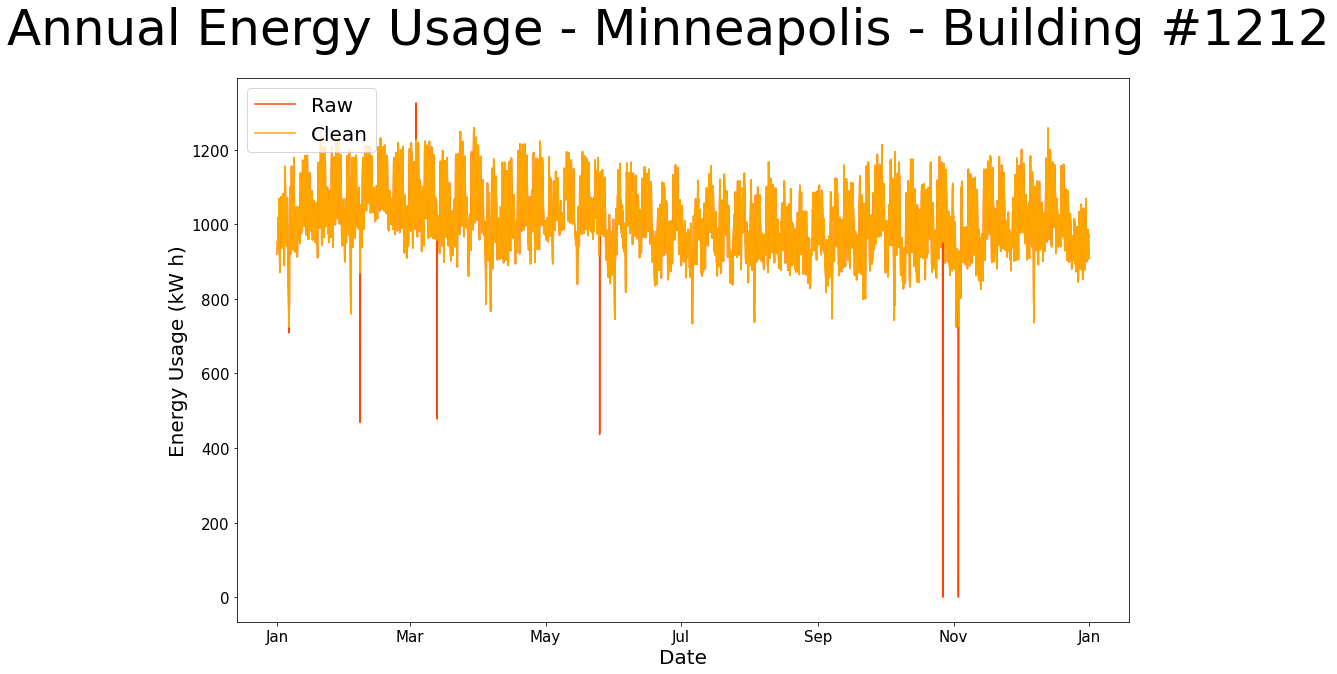

In [453]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20

building = 1212
site = site_dict[df_meta[df_meta.building_id == building]['site_id'].values[0]]

fig, ax = plt.subplots(figsize=(16, 10))

# Add x-axis and y-axis
ax.plot(df[(df.building_id == building) & (df.meter==0)].set_index('timestamp').index.values,
df[(df.building_id == building) & (df.meter==0)].set_index('timestamp')['meter_reading'],
color='orangered',label='Raw')

ax.plot(df_mod[(df_mod.building_id == building) & (df_mod.meter==0)].set_index('timestamp').index.values,
df_mod[(df_mod.building_id == building) & (df_mod.meter==0)].set_index('timestamp')['meter_reading'],
color='orange',label='Clean')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Energy Usage (kW h)")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
# Define the date format
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
ax.legend(loc=2,prop={'size': 20})

fig.suptitle(f"Annual Energy Usage - {site} - Building #{building}",size=50)

plt.show()

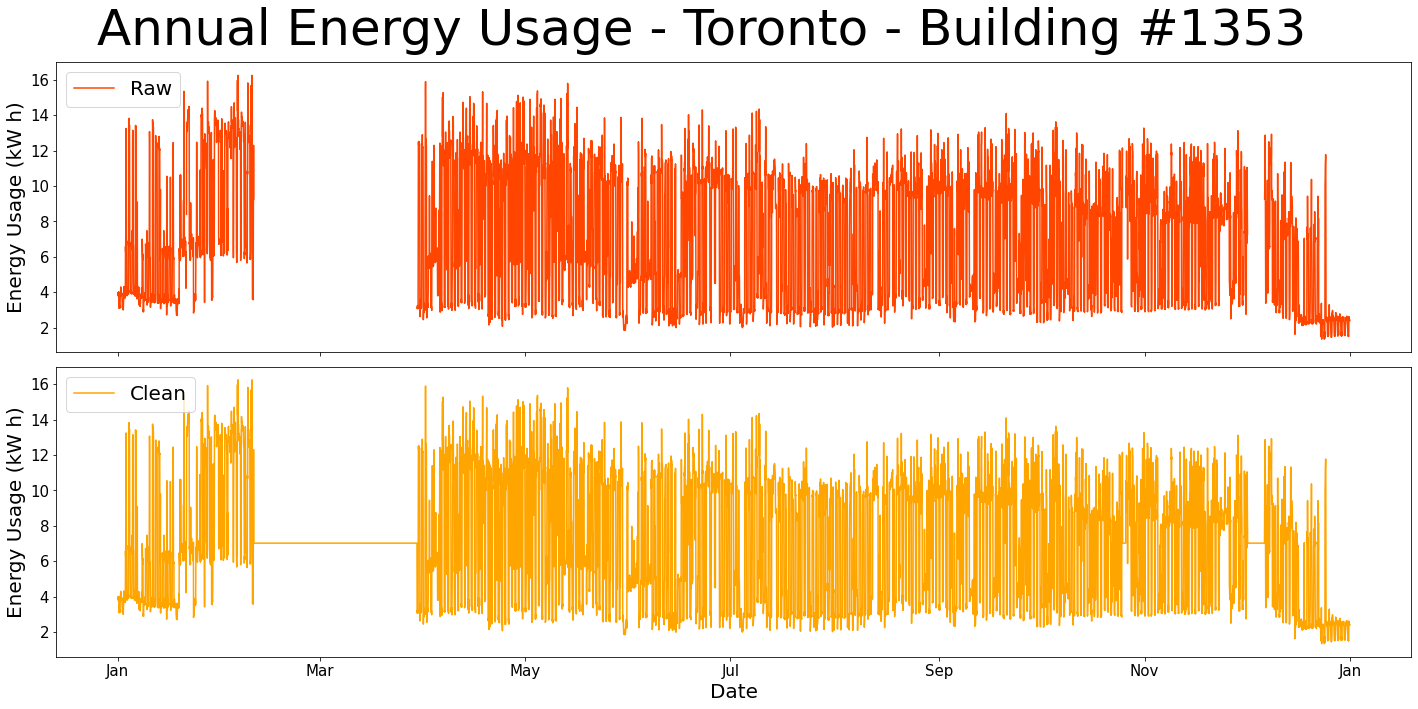

In [454]:
building = 1353
site = site_dict[df_meta[df_meta.building_id == building]['site_id'].values[0]]

fig, axes = plt.subplots(figsize=(20, 10),nrows=2,sharex=True,sharey=True)
fig.set_tight_layout(tight=True)
# Add x-axis and y-axis
axes[0].plot(df[(df.building_id == building) & (df.meter==0)].set_index('timestamp').resample('H').mean().index.values,
df[(df.building_id == building) & (df.meter==0)].set_index('timestamp').resample('H').mean()['meter_reading'],
color='orangered',label='Raw')

# ax.plot(df_mod[(df_mod.building_id == building) & (df_mod.meter==0)].set_index('timestamp').index.values,
axes[1].plot(df_mod[df_mod.building_id==building].set_index('timestamp').resample('H').mean().fillna(df_mod[df_mod.building_id==building]['meter_reading'].mean()).index.values,
df_mod[df_mod.building_id==building].set_index('timestamp').resample('H').mean().fillna(df_mod[df_mod.building_id==building]['meter_reading'].mean())['meter_reading'],
# df_mod[(df_mod.building_id == building) & (df_mod.meter==0)].set_index('timestamp')['meter_reading'],
color='orange',label='Clean')

for i in [0,1]:
       # Set title and labels for axes
       axes[1].set(xlabel="Date")
       axes[i].set(ylabel="Energy Usage (kW h)")
       # Define the date format
       date_form = DateFormatter("%b")
       axes[i].xaxis.set_major_formatter(date_form)
       axes[i].legend(loc=2,prop={'size': 20})
       axes[i].xaxis.label.set_size(20)
       axes[i].yaxis.label.set_size(20)

fig.suptitle(f"Annual Energy Usage - {site} - Building #{building}",size=50)
plt.show()

<AxesSubplot:xlabel='Primary Use', ylabel='Average Annual Energy Use (1 million kW h)'>

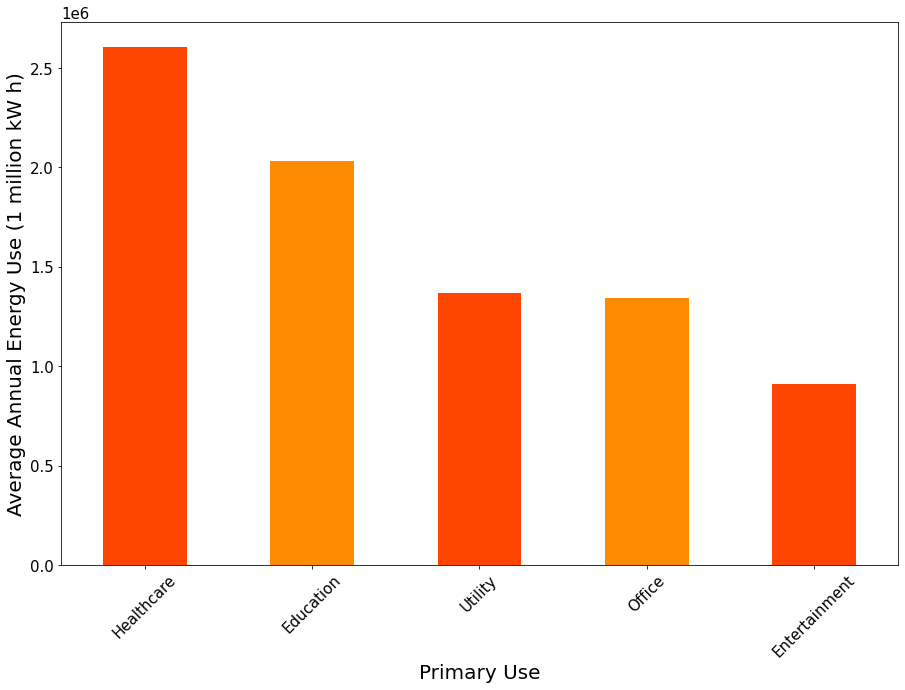

In [455]:
def change_ent(x):
    if x == 'Entertainment/public assembly':
        return 'Entertainment'
    else:
        return x

df_meta_energy['primary_use'] = df_meta_energy['primary_use'].map(change_ent)

df_meta_energy.groupby('primary_use').mean()['meter_reading'].sort_values(ascending=False)[:5].plot(kind='bar',rot=45,xlabel='Primary Use',ylabel='Average Annual Energy Use (1 million kW h)',figsize=(15,10),color=['orangered','darkorange'])

In [456]:
gbr = GradientBoostingRegressor()

gbr.fit(X_train_ohe,y_train['meter_reading'])

gbr.score(X_test_ohe,y_test['meter_reading'])

0.6433607244152281

In [457]:
y_test_hat = gbr.predict(X_test_ohe)
np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_test_hat)))

2488105.407508075